In [30]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Gráficas

> Ana Buendía Ruiz-Azuaga

In [41]:
def read_and_format_data(path, read_labels=True):
    data = pd.read_csv(path + "_features.csv")
    data.drop(columns="respondent_id", inplace=True)

    #Añado soluciones de training al final del fichero
    if read_labels:
        labels = pd.read_csv(path + "_labels.csv")
        labels.drop(columns="respondent_id", inplace=True)
        data = pd.concat((data, labels), axis=1)
    
    # --- Creo diccionarios
    age_groups = {'18 - 34 Years': 0,
                  '35 - 44 Years': 1,
                  '45 - 54 Years': 2,
                  '55 - 64 Years': 3,
                  '65+ Years': 4}
    
    sex = {"Female": 0,
           "Male": 1}
    
    race = {'White': 0,
            'Black': 1,
            'Other or Multiple': 2,
            'Hispanic': 3}
    
    education = {'< 12 Years': 0,
                 '12 Years': 1,
                 'Some College': 2,
                 'College Graduate': 3}
    
    income = {'Below Poverty': 0,
              '<= $75,000, Above Poverty': 1,
              '> $75,000': 2}

    marital = {'Not Married': 0, 
               'Married': 1}
    
    rent = {'Own': 0, 
            'Rent': 1}
    
    labor = {'Not in Labor Force' : 0,
             'Employed' : 1, 
             'Unemployed' : 2}
    
    msa = {'Non-MSA': 0, 
           'MSA, Not Principle  City': 1,
           'MSA, Principle City': 2}
    
    #DHago lo mismo con industry y occupation
    industry = {}
    j = 0
    for code in data["employment_industry"].unique():
        if not pd.isna(code):
            print(code,j)
            industry[code] = j
            j += 1    
    
    occupation = {}
    j = 0
    for code in data["employment_occupation"].unique():
        if not pd.isna(code):
            print(code,j)
            occupation[code] = j
            j += 1    
            
    region = {}
    j = 0
    for code in data["hhs_geo_region"].unique():
        if not pd.isna(code):
            region[code] = j
            j += 1    
    
    #Uno los diccionarios
    dictionaries = [age_groups, education, sex, race, income, marital, rent, 
                    labor, industry, occupation, msa, region]
    labels = ["age_group", "education", "sex", "race", "income_poverty", "marital_status", 
              "rent_or_own", "employment_status", "employment_industry", "employment_occupation",
              "census_msa", "hhs_geo_region"]
    
    #Reemplazo
    for dic,lab in zip(dictionaries,labels):
        for key in dic:
            data[lab].replace(key, dic[key], inplace=True)
            
    
    #Columnas cualitativas
    cualitative_cols = ["age_group", "race", "education", "income_poverty", "employment_status", 
                           "employment_industry", "employment_occupation", "census_msa", "hhs_geo_region"]
    
    #Almaceno las clases que guarda
    nclasses = [len(dic) for dic in [age_groups, race, education, income, labor, industry, occupation, msa, region]]
        
    return data, cualitative_cols, nclasses

In [42]:

data, cualitative_cols, n_classes = read_and_format_data("training_set")


pxcmvdjn 0
rucpziij 1
wxleyezf 2
saaquncn 3
xicduogh 4
ldnlellj 5
wlfvacwt 6
nduyfdeo 7
fcxhlnwr 8
vjjrobsf 9
arjwrbjb 10
atmlpfrs 11
msuufmds 12
xqicxuve 13
phxvnwax 14
dotnnunm 15
mfikgejo 16
cfqqtusy 17
mcubkhph 18
haxffmxo 19
qnlwzans 20
xgwztkwe 0
xtkaffoo 1
emcorrxb 2
vlluhbov 3
xqwwgdyp 4
ccgxvspp 5
qxajmpny 6
kldqjyjy 7
mxkfnird 8
hfxkjkmi 9
bxpfxfdn 10
ukymxvdu 11
cmhcxjea 12
haliazsg 13
dlvbwzss 14
xzmlyyjv 15
oijqvulv 16
rcertsgn 17
tfqavkke 18
hodpvpew 19
uqqtjvyb 20
pvmttkik 21
dcjcmpih 22


# Exploración de datos

Representamos los datos para comprender mejor el problema a estudiar y analizamos sus relaciones entre ellos.

In [45]:
# Imputamos valores con el valor mas comun
data_nonan = data.apply(lambda x: x.fillna(x.value_counts().index[0]))

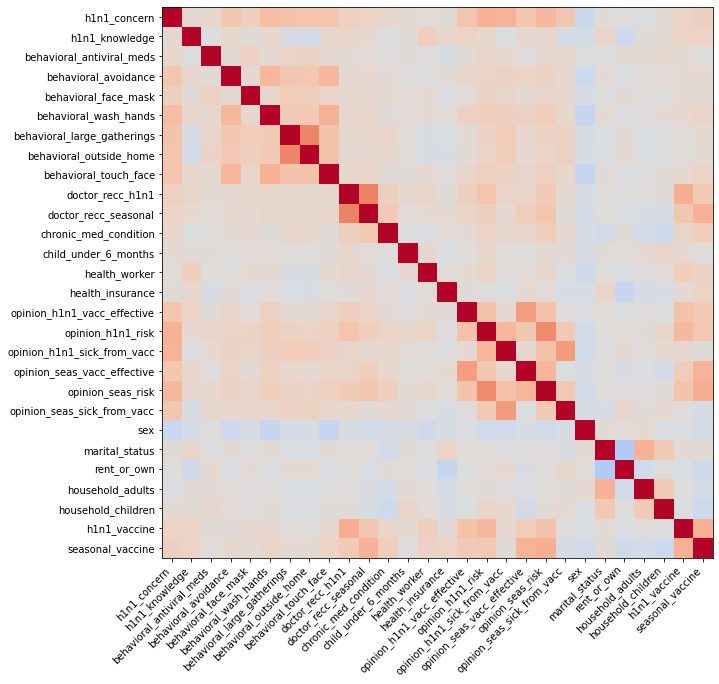

In [46]:
data_non_qualitative = data_nonan.drop(columns=cualitative_cols)
covariance = data_non_qualitative.corr().values
covariance = np.nan_to_num(covariance)

ticks = np.arange(data_non_qualitative.columns.size)

plt.figure(figsize=(10,10))
plt.imshow(covariance, vmin=-1, vmax=+1, cmap="coolwarm")
plt.xticks(ticks, data_non_qualitative.columns, rotation=45, ha='right')
plt.yticks(ticks, data_non_qualitative.columns, rotation="horizontal")
plt.tight_layout()
plt.savefig("correlaciones.pdf", bbox_inches="tight")
plt.show()



Buscamos los mejores valores para imputar los valores perdidos.

Analizamos qué códidos corresponden a trabajadores de la salud (HW), así como correlaciones demográficas. HW son como el 10% e  la población. 
Veamos las diferencias entre HW ynon-HW, si las hay.

% of HW: 0.1085483206649942


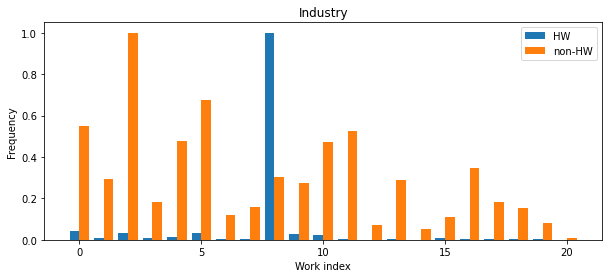

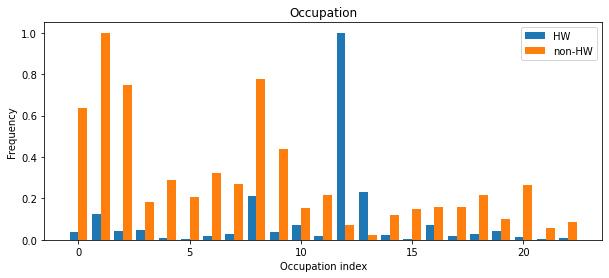

In [47]:
#Selecciono los health workers
health_workers = data["health_worker"] == 1
nhw = health_workers.sum()

print("% of HW: {0}".format(nhw / data.shape[0]))

bins = np.arange(-0.5, n_classes[5]+0.5, 1.0)

#Y los indices unicos asociados a ellos. Miro que porcentaje son
industry_hw, _  = np.histogram(data["employment_industry"][health_workers], bins=bins)
industry_non_hw,_ = np.histogram(data["employment_industry"][~health_workers], bins=bins)


plt.figure(figsize=(10,4))
bar_w = 0.4
xaxis_l = bins[:-1] + 0.5 * (1 - bar_w)
xaxis_r = bins[:-1] + 0.5 * (1 + bar_w)
plt.bar(xaxis_l, industry_hw / np.max(industry_hw), width=bar_w, label="HW")
plt.bar(xaxis_r, industry_non_hw / np.max(industry_non_hw), width=bar_w, label="non-HW")
plt.xlabel("Work index")
plt.ylabel("Frequency")
plt.legend(loc="best")
plt.title("Industry")
plt.savefig("industry.pdf")
plt.show()

bins = np.arange(-0.5, n_classes[6]+0.5, 1.0)

occupation_hw, _  = np.histogram(data["employment_occupation"][health_workers], bins=bins)
occupation_non_hw,_ = np.histogram(data["employment_occupation"][~health_workers], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.4
xaxis_l = bins[:-1] + 0.5 * (1 - bar_w)
xaxis_r = bins[:-1] + 0.5 * (1 + bar_w)
plt.bar(xaxis_l, occupation_hw / np.max(occupation_hw), width=bar_w, label="HW")
plt.bar(xaxis_r, occupation_non_hw / np.max(occupation_non_hw), width=bar_w, label="non-HW")
plt.xlabel("Occupation index")
plt.ylabel("Frequency")
plt.legend(loc="best")
plt.title("Occupation")
plt.savefig("occupation.pdf")
plt.show()

del industry_hw, industry_non_hw, occupation_hw, occupation_non_hw, bins, xaxis_l, xaxis_r

Ahora sabemos en lo que trabajan, veamos los que no están trabajando. Comprobamos también la correlación con employment, health insurance y income

Muchos están en not in labor force. Parecen jubilados.

% not employed HW: 15.039668851328043
% not in labor HW: 12.969989651604001


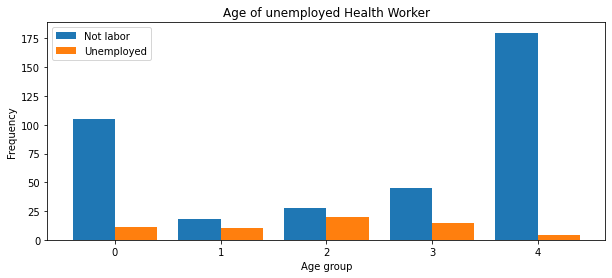

In [48]:
not_labor_employed_hw = (data["health_worker"] == 1) & (data["employment_status"] == 0)
unemployed_hw = (data["health_worker"] == 1) & (data["employment_status"] == 2)

total_not_working = not_labor_employed_hw.sum() +  unemployed_hw.sum()

print("% not employed HW: {0}".format(100* total_not_working / nhw))
print("% not in labor HW: {0}".format(100* not_labor_employed_hw.sum() / nhw))

age_not_labor = data["age_group"][not_labor_employed_hw]
age_unemp = data["age_group"][unemployed_hw]

bins = np.arange(-0.5, 5.5, 1.0)

age_not_labor, _  = np.histogram(age_not_labor, bins=bins)
age_unemp, _ = np.histogram(age_unemp, bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.4
xaxis_l = bins[:-1] + 0.5 * (1 - bar_w)
xaxis_r = bins[:-1] + 0.5 * (1 + bar_w)
plt.bar(xaxis_l, age_not_labor, width=bar_w, label="Not labor")
plt.bar(xaxis_r, age_unemp, width=bar_w, label="Unemployed")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Age of unemployed Health Worker")
plt.legend(loc="best")
plt.savefig("edad_hw.pdf")
plt.show()

del not_labor_employed_hw, unemployed_hw, total_not_working, age_not_labor, age_unemp, _

La mayoría de not in labor force parecen jubilados y estudiantes. Los desempleados están distribuidos por igual.

Lo comprobamos ahora en general para asegurarnos de que no es algo solo de HW.

% not employed: 42.09383307747033
% not in labor: 36.87797206724829


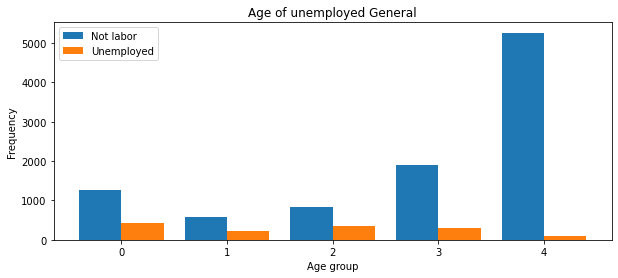

In [49]:
not_labor_employed=  (data["health_worker"] == 0) & (data["employment_status"] == 0)
unemployed = (data["health_worker"] == 0) & (data["employment_status"] == 2)

total_not_working = not_labor_employed.sum() +  unemployed.sum()

print("% not employed: {0}".format(100* total_not_working / data.shape[0]))
print("% not in labor: {0}".format(100* not_labor_employed.sum() / data.shape[0]))

age_not_labor = data["age_group"][not_labor_employed]
age_unemp = data["age_group"][unemployed]

bins = np.arange(-0.5, 5.5, 1.0)

age_not_labor, _  = np.histogram(age_not_labor, bins=bins)
age_unemp, _ = np.histogram(age_unemp, bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.4
xaxis_l = bins[:-1] + 0.5 * (1 - bar_w)
xaxis_r = bins[:-1] + 0.5 * (1 + bar_w)
plt.bar(xaxis_l, age_not_labor, width=bar_w, label="Not labor")
plt.bar(xaxis_r, age_unemp, width=bar_w, label="Unemployed")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Age of unemployed General")
plt.legend(loc="best")
plt.savefig("unemployed_edad.pdf")
plt.show()

del not_labor_employed, unemployed, total_not_working, age_not_labor, age_unemp, bins

Se ve mas o menos la misma tendencia.

veamos ahora con todos los datos demográficos, incluyendo la distirbución de edad de personas trabajando.

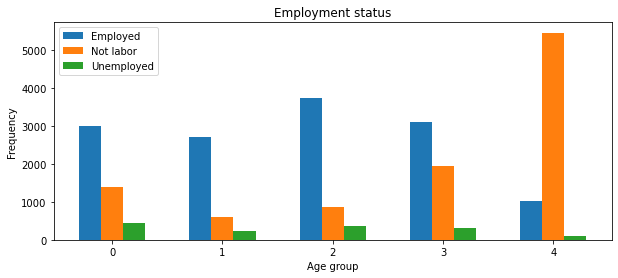

In [50]:
not_labor_employed= (data["employment_status"] == 0)
employed = (data["employment_status"] == 1)
unemployed = (data["employment_status"] == 2)

age_not_labor = data["age_group"][not_labor_employed]
age_emplo = data["age_group"][employed]
age_unemp = data["age_group"][unemployed]

bins = np.arange(-0.5, 5.5, 1.0)

age_not_labor, _  = np.histogram(age_not_labor, bins=bins)
age_emplo, _  = np.histogram(age_emplo, bins=bins)
age_unemp, _ = np.histogram(age_unemp, bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.2
xaxis_l = bins[:-1] + 0.5 - bar_w
xaxis_c = bins[:-1] + 0.5 
xaxis_r = bins[:-1] + 0.5 + bar_w
plt.bar(xaxis_l, age_emplo, width=bar_w, label="Employed")
plt.bar(xaxis_c, age_not_labor, width=bar_w, label="Not labor")
plt.bar(xaxis_r, age_unemp, width=bar_w, label="Unemployed")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Employment status")
plt.legend(loc="best")
plt.savefig("employment_status_segun_age.pdf")
plt.show()

del not_labor_employed, unemployed, age_not_labor, age_unemp, bins, employed, age_emplo

El desempleo es bajo para edades menores de 55 años y después sube. También hay muchos estudaintes en el primer grupo. 
¿Estos grupos tienen ingresos y seguro médico?


% Healthcare total: 47.54184296251919
% Healthcare employed: 49.269911504424776
% Healthcare NOT employed: 45.75948885677341
% Healthcare OLD: 14.000074886733815
% Healthcare YOUNG: 7.900550417493541


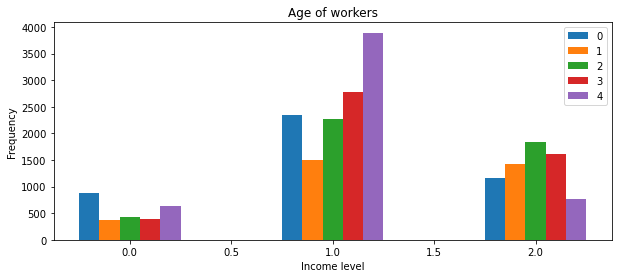

In [51]:
old_people = data["age_group"] == 4
young_people = data["age_group"] == 0

has_insurance = data["health_insurance"] == 1
employed = (data["employment_status"] == 1)

print("% Healthcare total: {0}".format( 100*(has_insurance).sum() /data.shape[0]))
print("% Healthcare employed: {0}".format( 100*(has_insurance & employed).sum() / employed.sum()))
print("% Healthcare NOT employed: {0}".format( 100*(has_insurance & ~employed).sum() / (~employed).sum()))

print("% Healthcare OLD: {0}".format( 100*(old_people & has_insurance).sum() /data.shape[0]))
print("% Healthcare YOUNG: {0}".format( 100*(young_people & has_insurance).sum() /data.shape[0]))

plt.figure(figsize=(10,4))

nbars = 5
half = nbars // 2
bins = np.arange(-0.5, 3.5, 1.0)
bar_w = 0.1

for bar in range(nbars):
    filter_age = data["age_group"] == bar
    income,_ = np.histogram(data["income_poverty"][filter_age], bins=bins)
    xaxis = bins[:-1] + 0.5 + (bar-half) *bar_w
    plt.bar(xaxis, income, width=bar_w, label=bar)
plt.xlabel("Income level")
plt.ylabel("Frequency")
plt.title("Age of workers")
plt.legend(loc="best")
plt.savefig("edad_segun_income.pdf")
plt.show()

del old_people, young_people, has_insurance, employed, bins, filter_age, income

The amount of people that does _not_ have healthcare is actually very worrisome. Even for the employed people, % is never higher than 50%. However it seems that unemployed people have it in the same amount. 
This could be a relevant point: if you don't have healthcare, _could your doctor recommend anything to you?_. If you don't have insurance, can you be diagnosed with chronic illnesses? Probably the combined effect of this variables has a huge impact on vaccination. Check it! 

Problem: there is MANY blank entries on health insurance, which coudl be a relevant variable. Let see if we can find where are those, correlating with age and employment.

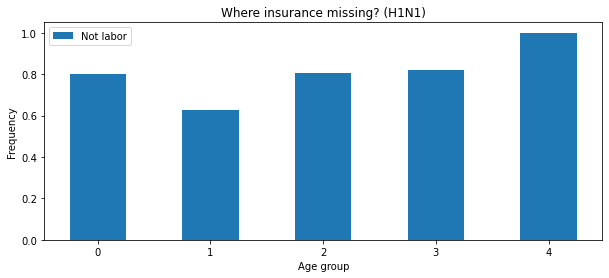

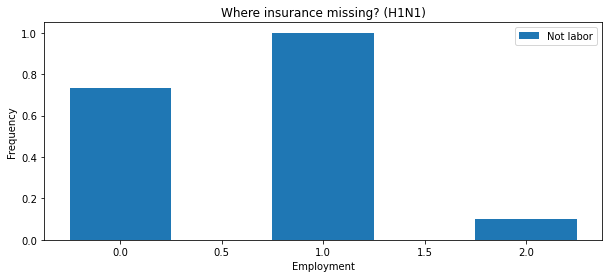

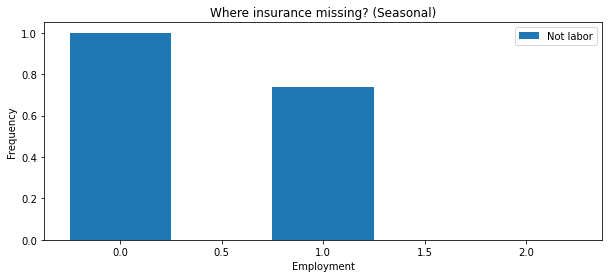

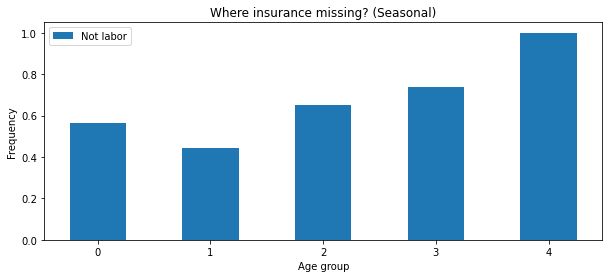

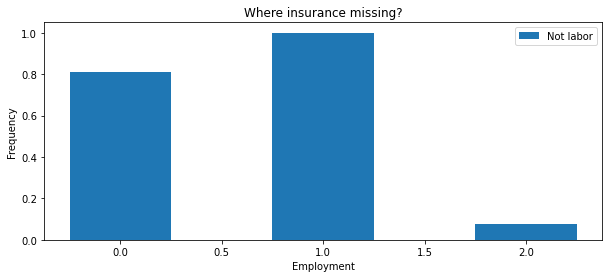

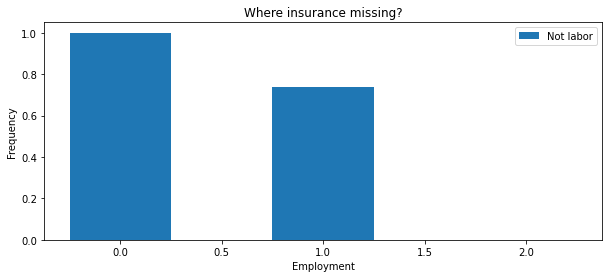

In [23]:
blank_insurance = data["health_insurance"].isna()
bins = np.arange(-0.5, 5.5, 1.0)

dist_blank, _  = np.histogram(data["age_group"][blank_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Where insurance missing? (H1N1)")
plt.legend(loc="best")
plt.savefig("insurance_agegroup_h1n1.pdf")
plt.show()


bins = np.arange(-0.5, 3.5, 1.0)

dist_blank, _  = np.histogram(data["employment_status"][blank_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Employment")
plt.ylabel("Frequency")
plt.title("Where insurance missing? (H1N1)")
plt.legend(loc="best")
plt.savefig("insurance_employment_h1n1.pdf")
plt.show()



dist_blank, _  = np.histogram(data["seasonal_vaccine"][blank_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Employment")
plt.ylabel("Frequency")
plt.title("Where insurance missing? (Seasonal)")
plt.legend(loc="best")
plt.savefig("insurance_employment_seas.pdf")
plt.show()



with_insurance = data["health_insurance"] == 1

bins = np.arange(-0.5, 5.5, 1.0)

dist_blank, _  = np.histogram(data["age_group"][with_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Where insurance missing? (Seasonal)")
plt.legend(loc="best")
plt.savefig("insurance_agegroup_seas.pdf")
plt.show()


bins = np.arange(-0.5, 3.5, 1.0)

dist_blank, _  = np.histogram(data["employment_status"][with_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Employment")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()

dist_blank, _  = np.histogram(data["seasonal_vaccine"][blank_insurance], bins=bins)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank/np.max(dist_blank), width=bar_w, label="Not labor")
plt.xlabel("Employment")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()


1463
1250


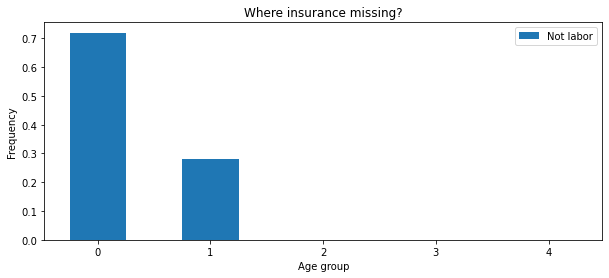

In [20]:
blank_insurance = data["employment_status"].isna()
bins = np.arange(-0.5, 5.5, 1.0)

print(data["employment_status"].isna().sum())
print((data["employment_status"].isna() & data["education"].isna()).sum())

dist_blank, _  = np.histogram(data["rent_or_own"][blank_insurance], bins=bins, density=True)

plt.figure(figsize=(10,4))
bar_w = 0.5
xaxis = bins[:-1] + 0.5 
plt.bar(xaxis, dist_blank, width=bar_w, label="Not labor")
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Where insurance missing?")
plt.legend(loc="best")
plt.show()